# Backtesting a 0DTE Bull Put Spread Strategy Using Historical Market Data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alpacahq/alpaca-py/blob/master/examples/options/options-zero-dte-backtest.ipynb)

### Strategy Overview
- **Sell a higher-strike put** (collect premium)
- **Buy a lower-strike put** (limit risk)  
- **Net result**: Receive credit upfront, profit if underlying stays above short strike

### Key Assumptions
- Expect an early assignment of OTM short put options
- Perfect liquidity (can exit at any time)
- Uses mid-point pricing of bid-ask spreads
- Single-day trading only (0DTE)

### How the Selection Process Works
The process used in this notebook scans through historical market data chronologically at **one-minute intervals** to find the first valid option pair that meets our trading criteria, holds it until an exit condition is met, then repeats every minute:
1. **Delta-based Selection**:
   - Short Put: Higher delta (closer to ATM) - generates premium income
   - Long Put: Lower delta (further OTM) - provides downside protection

2. **Spread Width Validation**:
   - Ensures risk/reward ratio stays within acceptable bounds
   - Configurable range (default: $2-$4) balances premium vs. risk

3. **Chronological Priority**:
   - Selects the first valid pair found in time sequence
   - Mimics real-world trading where timing matters

### Environment Configuration
- The notebook automatically detects whether it's running in Google Colab or a local IDE
- API keys are loaded differently based on the environment:
   - **Google Colab**: Uses [Colab's Secrets feature](https://x.com/GoogleColab/status/1719798406195867814) (set keys in the left sidebar) 
   - **Local IDE (e.g. VS Code, PyCharm)**: Uses environment variables from a `.env` file
- **Required API Keys**: You'll need to obtain and configure:
   - `ALPACA_API_KEY` and `ALPACA_SECRET_KEY` from your [Alpaca dashboard](https://app.alpaca.markets/dashboard/overview)
   - `DATABENTO_API_KEY` from your [Databento dashboard](https://databento.com/portal/keys)

### Data Sources
Dual API Integration for Comprehensive Market Data:
- **Alpaca Trading API**: Stock daily bars + 1-minute intraday data
- **Databento API**: Options 1-minute tick data with bid/ask spreads

This combination provides both the underlying stock context and detailed options pricing needed for accurate 0DTE backtesting, leveraging each platform's strengths.


In [38]:
!pip install pandas numpy scipy python-dotenv databento matplotlib alpaca-py

In [116]:
import os
import sys
from datetime import date, datetime, time, timedelta
from typing import Dict, List, Optional, Tuple
from zoneinfo import ZoneInfo

import databento as db
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from scipy.optimize import brentq
from scipy.stats import norm

from alpaca.data.historical.option import OptionHistoricalDataClient
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.trading.client import TradingClient
from alpaca.trading.enums import ContractType
from alpaca.trading.requests import GetCalendarRequest

## Step1: Setting UP the Environment and Trade Parameters

In [217]:
if 'google.colab' in sys.modules:
    # In Google Colab environment, we will fetch API keys from Secrets.
    # Please set ALPACA_API_KEY, ALPACA_SECRET_KEY, DATABENTO_API_KEY in Google Colab's Secrets from the left sidebar
    from google.colab import userdata
    ALPACA_API_KEY = userdata.get("ALPACA_API_KEY")
    ALPACA_SECRET_KEY = userdata.get("ALPACA_SECRET_KEY")
    DATABENTO_API_KEY = userdata.get("DATABENTO_API_KEY")
else:
    # Please safely store your API keys and never commit them to the repository (use .gitignore)
    # Load environment variables from environment file (e.g., .env)
    load_dotenv()
    # API credentials for Alpaca's Trading API and Databento API
    ALPACA_API_KEY = os.environ.get('ALPACA_API_KEY')
    ALPACA_SECRET_KEY = os.environ.get('ALPACA_SECRET_KEY')
    DATABENTO_API_KEY = os.getenv("DATABENTO_API_KEY")

## We use paper environment for this example
ALPACA_PAPER_TRADE = True # Please do not modify this. This example is for paper trading only.

# Below are the variables for development this documents (Please do not change these variables)
TRADE_API_URL = None
TRADE_API_WSS = None
DATA_API_URL = None
OPTION_STREAM_DATA_WSS = None

In [218]:
# Initialize Alpaca clients
trade_client = TradingClient(api_key=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY, paper=ALPACA_PAPER_TRADE)
option_historical_data_client = OptionHistoricalDataClient(api_key=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY)
stock_data_client = StockHistoricalDataClient(api_key=ALPACA_API_KEY, secret_key=ALPACA_SECRET_KEY)

In [219]:
# Initialize Databento client
databento_client = db.Historical(DATABENTO_API_KEY)

In [277]:
# Underlying symbol
underlying_symbol = 'SPY'

# Risk free rate for the options greeks and IV calculations
RISK_FREE_RATE = 0.01

# Set the timezone
NY_TZ = ZoneInfo('America/New_York')

# Get current date in US/Eastern timezone
today = datetime.now(NY_TZ).date()
start_date = today - timedelta(days=8) # Start of backtesting period: 8 trading days of 0DTE strategy data
end_date = today - timedelta(days=2)   # End of backtesting period: excludes recent data

# Set buffer percentage for the strike price range
BUFFER_PCT = 0.05

# Define delta thresholds
SHORT_PUT_DELTA_RANGE = (-0.60, -0.20) # Short put selection: delta between -0.60 to -0.20 for bull put spread
LONG_PUT_DELTA_RANGE = (-0.40, -0.20) # Long put selection: delta between -0.40 to -0.20 for bull put spread

# Set stop loss threshold threshold (2 times of the initial delta)
DELTA_STOP_LOSS_THRES = 2

# Set target profit and stop-loss levels (50% of the initial credit)
TARGET_STOP_LOSS_PERCENTAGE = 0.5

## Step2: Getting Historical Stock Daily Bar Data

**Purpose**: Optimize data retrieval by identifying daily price ranges. We use these daily price boundaries (with a small buffer called `buffer_pct`). This allows us to focus on realistic strike prices near the market price (where bull put spreads are typically placed) rather than downloading all available one-minute option contracts and equities bars data.

* The `get_daily_stock_bars_df` function fetches daily price bars for the underlying stock (e.g., SPY) within the specified date range using Alpaca's API.

In [279]:
def get_daily_stock_bars_df(symbol: str, start_date: date, end_date: date) -> pd.DataFrame:
    """
    Retrieve daily stock bars and replace timestamps with actual market close times.
    
    Used to establish daily high/low price boundaries for option strike selection.
    Gets actual market hours from Alpaca's trading calendar to handle early/late market closes.
    
    Args:
        symbol: Stock ticker symbol (e.g., 'SPY')
        start_date: Start date for data retrieval
        end_date: End date for data retrieval
    
    Returns:
        pd.DataFrame: Daily OHLCV data with expiration_datetime index containing 
                     actual market close times from Alpaca's trading calendar
    """

    req = StockBarsRequest(
        symbol_or_symbols=symbol,
        timeframe=TimeFrame(amount=1, unit=TimeFrameUnit.Day),
        start=start_date,
        end=end_date,
    )
    resp = stock_data_client.get_stock_bars(req)
    bars = resp.data[symbol]

    rows = [b.model_dump() for b in bars]
    df = pd.DataFrame(rows)

    # Get market calendar for the same date range
    calendar_request = GetCalendarRequest(start=start_date, end=end_date)
    calendar = trade_client.get_calendar(calendar_request)
    market_close_lookup = {cal.date: cal.close.astimezone(NY_TZ) for cal in calendar}

    # Replace timestamp with actual market close datetime as index
    df['expiration_datetime'] = df['timestamp'].dt.date.map(market_close_lookup.get)
    df = df.drop(columns=['timestamp']).set_index("expiration_datetime").sort_index()

    return df

In [284]:
stock_bars_data = get_daily_stock_bars_df(symbol=underlying_symbol, start_date=start_date, end_date=end_date)

In [285]:
# Get the first 2 rows of the stock bars data
stock_bars_data.head(2)

,symbol,open,high,low,close,volume,trade_count,vwap
expiration_datetime,,,,,,,,
2025-07-18 17:00:00-04:00,SPY,629.30,629.47,626.46,627.58,65621496.0,594577.0,627.596472
2025-07-21 17:00:00-04:00,SPY,628.77,631.54,628.34,628.77,63374984.0,709907.0,630.174770


## Step3: Retrieving Historical Minute-by-Minute Stock and Options Data by Expiration

**Purpose**: This section generates the universe of relevant put option contracts for backtesting by creating option symbols within a realistic strike price range (±5% buffer around daily high/low prices) and grouping by expiration date based on daily stock bars data. This targeted approach ensures we only fetch option data that traders would realistically consider for bull put spreads, rather than downloading all available contracts.

* `calculate_strike_price_range` calculates the range of option strike prices to consider based on the stock's daily high/low prices with a buffer percentage.
* `generate_put_option_symbols` uses the strike price range to generate standardized option symbol strings for put options within the specified range.
* `collect_option_symbols_by_expiration` creates a list of all relevant option symbols grouped by expiration date for simulating the 0DTE strategy.

In [286]:
def calculate_strike_price_range(high_price: float, low_price: float, buffer_pct: float = 0.05) -> Tuple[float, float]:
    """
    Calculate strike price boundaries with buffer around daily high/low prices.

    Args:
        high_price: Daily high price
        low_price: Daily low price  
        buffer_pct: Percentage buffer to expand range (default 5%)

    Returns:
        Tuple[float, float]: (min_strike, max_strike) boundaries
    """
    min_strike = low_price * (1 - buffer_pct)
    max_strike = high_price * (1 + buffer_pct)

    return min_strike, max_strike

In [311]:
# Show only the first row
first_row = stock_bars_data.iloc[0]
print(first_row)
min_strike, max_strike = calculate_strike_price_range(first_row['high'], first_row['low'], buffer_pct=BUFFER_PCT)
print(f"{first_row.name.date()}: min_strike=${min_strike:.2f}, max_strike=${max_strike:.2f}")

symbol                SPY
open                629.3
high               629.47
low                626.46
close              627.58
volume         65621496.0
trade_count      594577.0
vwap           627.596472
Name: 2025-07-18 17:00:00-04:00, dtype: object
2025-07-18: min_strike=$595.14, max_strike=$660.94


In [288]:
def generate_put_option_symbols(
        underlying: str, 
        expiration_datetime: datetime, 
        min_strike: float, 
        max_strike: float, 
        strike_increment: float = 1
        ) -> List[str]:
    """
    Generate put option symbols for the given parameters.

    Uses ceiling function to round min_strike UP to nearest whole dollar
    (e.g., $590.96 becomes $591) since options usually trade at integer strikes.

    Args:
        underlying: Underlying symbol (e.g., 'SPY')
        expiration_datetime: Option expiration datetime
        min_strike: Minimum strike price
        max_strike: Maximum strike price
        strike_increment: Strike price increment (default 1)

    Returns:
        List[str]: Formatted option symbols (e.g., 'SPY250616P00571000')
    """
    option_symbols = []

    # Format expiration datetime as date: YYMMDD
    expiration_date = expiration_datetime.date()
    exp_str = expiration_date.strftime("%y%m%d")

    # Generate strikes in increments (rounds UP to the nearest integer)
    current_strike = np.ceil(min_strike / strike_increment) * strike_increment

    while current_strike <= max_strike:
        # Format strike price as 8-digit integer (multiply by 1000)
        strike_formatted = f"{int(current_strike * 1000):08d}"

        # Create option symbol: SPY + YYMMDD + P + 8-digit strike
        option_symbol = f"{underlying}{exp_str}P{strike_formatted}"
        option_symbols.append(option_symbol)

        current_strike += strike_increment

    return option_symbols

In [289]:
def collect_option_symbols_by_expiration(
        stock_bars_data: pd.DataFrame, 
        underlying_symbol: str, 
        buffer_pct: float
        ) -> Dict[pd.Timestamp, List[str]]:
    """
    Collect option symbols grouped by expiration datetime for 0DTE backtesting.
    
    For each trading day in the stock bars data, generates put option symbols
    within a realistic strike range and groups them by expiration date.

    Args:
        stock_bars_data: DataFrame containing daily OHLCV data with timestamp index
        underlying_symbol: Stock symbol (e.g., 'SPY') for option generation
        buffer_pct: Buffer percentage to expand strike range around daily high/low

    Returns:
        Dict[pd.Timestamp, List[str]]: Dictionary mapping expiration datetime (e.g., Timestamp('2025-07-21 16:00:00')) 
                                       to lists of option symbols for that date
    """
    # Collect all symbols
    option_symbols_by_expiration = {}

    for index, row in stock_bars_data.iterrows():
        min_strike, max_strike = calculate_strike_price_range(row['high'], row['low'], buffer_pct=buffer_pct)

        option_symbols = generate_put_option_symbols(underlying_symbol, expiration_datetime=index, min_strike=min_strike, max_strike=max_strike, strike_increment=1)

        # Group symbols by expiration date
        if index not in option_symbols_by_expiration:
            option_symbols_by_expiration[index] = []

        option_symbols_by_expiration[index].extend(option_symbols)

    return option_symbols_by_expiration

In [290]:
option_symbols_by_expiration = collect_option_symbols_by_expiration(stock_bars_data, underlying_symbol, buffer_pct=BUFFER_PCT)

In [312]:
# Show just the keys (dates) to understand the structure
keys = list(option_symbols_by_expiration.keys())
keys

[Timestamp('2025-07-18 17:00:00-0400', tz='America/New_York'),
 Timestamp('2025-07-21 17:00:00-0400', tz='America/New_York'),
 Timestamp('2025-07-22 17:00:00-0400', tz='America/New_York'),
 Timestamp('2025-07-23 17:00:00-0400', tz='America/New_York')]

In [292]:
# Compare calculated vs generated strike ranges. You can see that the generated strike ranges are within the calculated range.
first_day = stock_bars_data.head(1).iloc[0]
calc_min, calc_max = first_day['low'] * (1-BUFFER_PCT), first_day['high'] * (1+BUFFER_PCT)
print(f"Calculated range: ${calc_min:.2f} - ${calc_max:.2f}")

symbols = option_symbols_by_expiration[keys[0]] # Show the first expiration date's option symbols
symbols[:2] + ['...'] + symbols[-2:] # Show first 2 and last 2 option symbols to see the strike range

Calculated range: $595.14 - $660.94


['SPY250718P00596000',
 'SPY250718P00597000',
 '...',
 'SPY250718P00659000',
 'SPY250718P00660000']

* The `get_historical_stock_and_option_data` function uses the collection of all relevant option symbols grouped by expiration timestamp from the `collect_option_symbols_by_expiration` function and retrieves minute-by-minute market data for both stock and options using Alpaca and Databento APIs, providing the data needed for realistic backtesting.

In [293]:
def extract_strike_price_from_symbol(symbol: str) -> float:
    """
    Extract strike price from option symbol.
    Converts last 8 digits of option symbol to strike price by dividing by 1000.
    
    Args:
        symbol: Option symbol (e.g., 'SPY250616P00571000')
    
    Returns:
        float: Strike price (e.g., 571.0) or 0.0 if invalid format
    """
    # Option symbols typically have format: TICKER + YYMMDD + (C/P) + 8-digit strike price
    # The last 8 digits represent strike price * 1000
    try:
        # Extract the last 8 digits and convert to strike price
        strike_str = symbol[-8:]
        strike_price = float(strike_str) / 1000.0
        return strike_price
    except (ValueError, IndexError):
        print(f"Warning: Could not extract strike price from symbol {symbol}")
        return 0.0

In [ ]:
def get_historical_stock_and_option_data(
        option_symbols_by_expiration: Dict[pd.Timestamp, List[str]], 
        underlying_symbol: str
) -> pd.DataFrame:
    """
    Get combined option and stock data as a DataFrame.
    Returns options data with stock close prices merged by timestamp for easier inspection.

    Args:
        option_symbols_by_expiration: Dictionary mapping dates to option symbol lists
        underlying_symbol: Stock symbol for underlying asset

    Returns:
        pd.DataFrame: Combined options and stock data with renamed columns
    """
    all_data_frames = []

    for expiration_datetime, symbols_list in option_symbols_by_expiration.items():
        # Create start datetime at 9:30 AM for the same date
        start_datetime = expiration_datetime.replace(hour=9, minute=30, second=0, microsecond=0)
        # Use expiration_datetime directly as end_datetime (already contains actual market close)
        end_datetime = expiration_datetime

        # Get stock bar data (1 minute interval) for the specified underlying symbol
        req = StockBarsRequest(
            symbol_or_symbols=underlying_symbol,
            timeframe=TimeFrame(amount=1, unit=TimeFrameUnit.Minute),
            start=start_datetime,
            end=end_datetime
        )
        stock_res = stock_data_client.get_stock_bars(req)

        # Create a dictionary of stock close prices by timestamp for quick lookup
        stock_close_by_timestamp = {}
        if underlying_symbol in stock_res.data:
            for bar in stock_res.data[underlying_symbol]:
                stock_close_by_timestamp[bar.timestamp] = bar.close
            print(f"Retrieved 1-minute stock bars for {underlying_symbol}: {len(stock_res.data[underlying_symbol])} total bars")

            # Transform options symbols to format required by databento (add spaces)
            formatted_option_symbols = [f"{symbol[:3]}   {symbol[3:]}" for symbol in symbols_list]

            # Get option tick data using databento client
            option_df = databento_client.timeseries.get_range(
                dataset="OPRA.PILLAR",
                schema="cbbo-1m",
                symbols=formatted_option_symbols,
                start=start_datetime,
                end=end_datetime,
            ).to_df()

            if not option_df.empty:
                # Add derived columns to option_df
                option_df['option_symbol'] = option_df['symbol'].str.replace(' ', '')
                option_df['strike_price'] = option_df['option_symbol'].apply(extract_strike_price_from_symbol)
                option_df['midpoint'] = (option_df['bid_px_00'] + option_df['ask_px_00']) / 2
                option_df['expiry'] = end_datetime.astimezone(ZoneInfo("UTC"))
                
                # Map stock close prices using timestamp lookup (handles one-to-many correctly)
                option_df['underlying_close'] = option_df.index.map(stock_close_by_timestamp)
                
                # Select and rename columns as needed
                final_df = option_df[[
                    'option_symbol', 'strike_price', 'price', 'bid_px_00', 'ask_px_00', 
                    'midpoint', 'bid_sz_00', 'ask_sz_00', 'expiry', 'underlying_close'
                ]].rename(columns={
                    'price': 'close',
                    'bid_px_00': 'bid',
                    'ask_px_00': 'ask', 
                    'bid_sz_00': 'bid_size',
                    'ask_sz_00': 'ask_size'
                })
                
                # Reset index to make timestamp a column and rename it
                final_df.reset_index(inplace=True)
                final_df.rename(columns={'ts_recv': 'timestamp'}, inplace=True)
                
                all_data_frames.append(final_df)
                print(f"Retrieved data for {len(formatted_option_symbols)} options symbols: {len(option_df)} total rows")
            else:
                print(f"No data found for options symbols: {formatted_option_symbols}")

    # Combine all DataFrames
    if all_data_frames:
        result_df = pd.concat(all_data_frames, ignore_index=True)
        return result_df.sort_values('timestamp').reset_index(drop=True)
    else:
        return pd.DataFrame()

In [304]:
historical_stock_and_option_data = get_historical_stock_and_option_data(option_symbols_by_expiration, underlying_symbol)

Retrieved 1-minute stock bars for SPY: 446 total bars
Retrieved data for 65 options symbols: 26010 total rows
Retrieved 1-minute stock bars for SPY: 451 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250721P00651000, SPY   250721P00652000, SPY   250721P00653000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 67 options symbols: 22593 total rows
Retrieved 1-minute stock bars for SPY: 449 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250722P00651000, SPY   250722P00652000, SPY   250722P00653000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 67 options symbols: 23420 total rows
Retrieved 1-minute stock bars for SPY: 451 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250723P00651000, SPY   250723P00652000, SPY   250723P00653000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 67 options symbols: 21785 total rows


In [306]:
# Show first 2 and last 2 rows of the stock_option_historical_data_by_timestamp
pd.concat([historical_stock_and_option_data.head(2), historical_stock_and_option_data.tail(2)])

,timestamp,option_symbol,strike_price,close,bid,ask,midpoint,bid_size,ask_size,expiry,underlying_close
0,2025-07-18 13:31:00+00:00,SPY250718P00611000,611.0,0.02,0.02,0.03,0.025,5235,12969,2025-07-18 21:00:00+00:00,629.14
1,2025-07-18 13:31:00+00:00,SPY250718P00610000,610.0,0.02,0.01,0.02,0.015,16614,7509,2025-07-18 21:00:00+00:00,629.14
93806,2025-07-23 20:16:00+00:00,SPY250723P00633000,633.0,0.01,0.01,0.02,0.015,110,215,2025-07-23 21:00:00+00:00,634.40
93807,2025-07-23 20:16:00+00:00,SPY250723P00634000,634.0,0.07,0.07,0.08,0.075,62,65,2025-07-23 21:00:00+00:00,634.40


## Step 4: Implementing Options Greeks and IV Calculations from Historical Option Bars

**Purposes**: Calculate delta and implied volatility for each 1-minute option tick to determine which options qualify for our bull put spread. Delta measures price sensitivity to stock movements, while implied volatility helps us determine if the option is fairly priced. Both help us select appropriate short puts (higher delta) and long puts (lower delta) for the strategy.

* The `calculate_delta_historical` function uses `calculate_implied_volatility` and computes the delta of an option using historical data, considering the time to expiry, implied volatility, and option type. It adjusts for options nearing expiration by setting delta based on intrinsic value when necessary.

* The `calculate_implied_volatility` function estimates the implied volatility of an option by solving for the volatility that matches the observed option price, using the Black-Scholes model. It handles edge cases where the option price is close to intrinsic value by returning a near-zero volatility.

In [196]:
# Calculate implied volatility
def calculate_implied_volatility(option_price: float, S: float, K: float, T: float, r: float, option_type: str) -> Optional[float]:
    """
    Calculate implied volatility using the Black-Scholes model.

    Args:
        option_price: Market price of the option
        S: Current stock price (underlying asset price)
        K: Strike price of the option
        T: Time to expiration in years
        r: Risk-free interest rate
        option_type: Type of option (ContractType.CALL or ContractType.PUT)

    Returns:
        Implied volatility as a float, or None if calculation fails
    """
    # Define a reasonable range for sigma
    sigma_lower = 1e-6
    sigma_upper = 5.0  # Adjust upper limit if necessary

    # Check if the option is out-of-the-money and price is close to zero
    intrinsic_value = max(0, (S - K) if option_type == 'call' else (K - S))
    if option_price <= intrinsic_value + 1e-6:
        # print("Option price is close to intrinsic value; implied volatility is near zero.") # Uncomment for checking the status
        return 0.0

    # Define the function to find the root
    def option_price_diff(sigma: float) -> float:
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        if option_type == 'call':
            price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif option_type == 'put':
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        return price - option_price

    try:
        return brentq(option_price_diff, sigma_lower, sigma_upper)
    except ValueError as e:
        print(f"Failed to find implied volatility: {e}")
        return None

In [197]:
# Calculate historical option Delta
def calculate_delta_historical(
    option_price: float, 
    strike_price: float, 
    expiry: pd.Timestamp, 
    underlying_price: float, 
    risk_free_rate: float, 
    option_type: str, 
    timestamp: pd.Timestamp
) -> Optional[float]:
    """
    Calculate option delta using historical data and the Black-Scholes model.

    Args:
        option_price: Market price of the option
        strike_price: Strike price of the option
        expiry: Option expiration datetime
        underlying_price: Current price of underlying asset
        risk_free_rate: Risk-free interest rate
        option_type: Type of option ('call' or 'put')
        timestamp: Current timestamp for calculation

    Returns:
        Option delta as a float, or None if calculation fails
    """
    # Calculate the time to expiry in years
    T = (expiry - timestamp).total_seconds() / (365 * 24 * 60 * 60)
    # Set minimum T to avoid zero
    T = max(T, 1e-6)

    if T == 1e-6:
        print("Option has expired or is expiring now; setting delta based on intrinsic value.")
        if option_type == 'put':
            return -1.0 if underlying_price < strike_price else 0.0
        else:
            return 1.0 if underlying_price > strike_price else 0.0

    implied_volatility = calculate_implied_volatility(option_price, underlying_price, strike_price, T, risk_free_rate, option_type)
    if implied_volatility is None or implied_volatility <= 1e-6:
        # print("Implied volatility could not be determined, skipping delta calculation.")
        return None

    d1 = (np.log(underlying_price / strike_price) + (risk_free_rate + 0.5 * implied_volatility ** 2) * T) / (implied_volatility * np.sqrt(T))
    delta = norm.cdf(d1) if option_type == 'call' else -norm.cdf(-d1)
    return delta

## Step 5: Finding Short and Long Puts for a 0DTE Bull Put Spread

**Purposes**: This is the main algorithmic trading logic that forms the core of our 0DTE bull put spread options strategy. The `find_short_and_long_puts` function implements the systematic approach to identify and select optimal option pairs for bull put spreads.

**Note**: You can uncomment print functions within `find_short_and_long_puts` to assess the algorithm as well.


<b>Algorithm Flow</b>

```json
For each timestamp in historical data (starting from the earliest timestamp):
└── For each 1-minute option tick in that timestamp (e.g. '2025-05-10 13:45:00' UTC)
    ├── Calculate option delta
    ├── Check if delta fits short put criteria → Store if match
    ├── Check if delta fits long put criteria → Store if match
    └── If both options found:
        ├── Validate spread width
        ├── If valid → Return pair (STOP)
        └── If invalid → Reset and continue search
```

In [198]:
def create_option_series_historical(
    option_symbol: str, 
    strike_price: float, 
    underlying_price: float, 
    delta: float, 
    option_price: float, 
    timestamp: pd.Timestamp, 
    expiry: pd.Timestamp
) -> pd.Series:
    """
    Create option Series from historical tick data for DataFrame compatibility.
    
    Args:
        option_symbol: Option contract symbol (e.g., 'SPY250721P00630000')
        strike_price: Strike price of the option
        underlying_price: Current price of the underlying asset
        delta: Calculated delta value for the option
        option_price: Market price of the option (midpoint)
        timestamp: Current timestamp of the data
        expiry: Expiration date of the option
    
    Returns:
        pandas Series containing option data with labeled fields
    """
    return pd.Series({
        'option_symbol': option_symbol,
        'strike_price': strike_price,
        'underlying_price': underlying_price,
        'delta': delta,
        'option_price': option_price,
        'timestamp': timestamp,
        'expiration_date': expiry,
    })

In [335]:
def find_short_and_long_puts(
    historical_stock_and_option_data: pd.DataFrame,
    risk_free_rate,
    short_put_delta_range: List,
    long_put_delta_range: List,
    spread_width=(2, 4),
    option_type=ContractType.PUT
):
    """
    Identify the short put and long put from the options chain using DataFrame input.
    Returns pandas Series containing details of the selected options.

    Args:
        historical_stock_and_option_data: DataFrame with options historical data
        risk_free_rate: Risk-free rate for options calculations  
        short_put_delta_range: Delta range for short put selection (e.g., (-0.60, -0.20))
        long_put_delta_range: Delta range for long put selection (e.g., (-0.40, -0.20))
        spread_width: Tuple of (min_width, max_width) for spread in dollars (default: (2, 4))
        option_type: Type of option (ContractType.PUT or ContractType.CALL)

    Returns:
        Tuple[pd.Series, pd.Series]: Two pandas Series objects containing:
            - short_put: Series with option_symbol, strike_price, underlying_price, 
                        delta, option_price, timestamp, expiration_date
            - long_put: Series with same fields as short_put
            Raises ValueError if no valid spread is found after exhaustive search
    """
    short_put = None
    long_put = None

    # Group by timestamp and iterate chronologically
    for timestamp, group in historical_stock_and_option_data.groupby('timestamp'):
        print(f"Analyzing timestamp: {timestamp}")

        for idx, row in group.iterrows():
            option_symbol = row['option_symbol']

            # Get tick data from DataFrame row
            underlying_price = row['underlying_close']
            option_price = row['midpoint']
            strike_price = row['strike_price']
            expiry = row['expiry']
            current_timestamp = row['timestamp']

            # Skip if any essential data is missing
            if pd.isna(option_price) or pd.isna(underlying_price):
                # print(f"Missing essential data for {option_symbol} at timestamp: {timestamp}")
                continue

            # Calculate delta
            delta = calculate_delta_historical(
                option_price=option_price,
                strike_price=strike_price,
                expiry=expiry,
                underlying_price=underlying_price,
                risk_free_rate=risk_free_rate,
                option_type=option_type,
                timestamp=current_timestamp
            )
            # print(f"Delta for {option_symbol} is: {delta}")
            
            # Skip this option if delta calculation failed
            if delta is None:
                # print(f"Delta calculation failed for {option_symbol} at timestamp: {timestamp}")
                continue

            # Check if this option meets short put criteria
            if short_put is None and short_put_delta_range[0] <= delta <= short_put_delta_range[1]:
                short_put = create_option_series_historical(option_symbol, strike_price, underlying_price, delta, option_price, current_timestamp, expiry)
            elif long_put is None and long_put_delta_range[0] <= delta <= long_put_delta_range[1]:
                long_put = create_option_series_historical(option_symbol, strike_price, underlying_price, delta, option_price, current_timestamp, expiry)


            # Check spread width only when both options are found
            if short_put is not None and long_put is not None:
                current_spread_width = abs(short_put['strike_price'] - long_put['strike_price'])
                if not (spread_width[0] <= current_spread_width <= spread_width[1]):
                    # print(f"Spread width of {current_spread_width} is outside the target range of ${spread_width[0]}-${spread_width[1]}; resetting search.")
                    # Reset both options to continue searching
                    short_put = None
                    long_put = None
                    continue
                else:
                    # Exit immediately when valid pair found
                    print(f"Valid spread found with width ${current_spread_width} at timestamp: {timestamp} for {short_put['option_symbol']} and {long_put['option_symbol']} at underlying price: {underlying_price}")
                    return short_put, long_put

    # If we reach here, no valid spread was found after exhaustive search
    raise ValueError("No valid spread found in the given data after exhaustive search")

In [336]:
SPREAD_WIDTH = (2, 4)
short_put, long_put = find_short_and_long_puts(historical_stock_and_option_data, RISK_FREE_RATE, SHORT_PUT_DELTA_RANGE, LONG_PUT_DELTA_RANGE, SPREAD_WIDTH, option_type=ContractType.PUT)
short_put, long_put

Analyzing timestamp: 2025-07-18 13:31:00+00:00
Valid spread found with width $2.0 at timestamp: 2025-07-18 13:31:00+00:00 for SPY250718P00629000 and SPY250718P00627000 at underlying price: 629.14


(option_symbol              SPY250718P00629000
 strike_price                            629.0
 underlying_price                       629.14
 delta                               -0.481692
 option_price                             1.27
 timestamp           2025-07-18 13:31:00+00:00
 expiration_date     2025-07-18 21:00:00+00:00
 dtype: object,
 option_symbol              SPY250718P00627000
 strike_price                            627.0
 underlying_price                       629.14
 delta                               -0.266741
 option_price                            0.565
 timestamp           2025-07-18 13:31:00+00:00
 expiration_date     2025-07-18 21:00:00+00:00
 dtype: object)

## Step 6: Executing a 0DTE Bull Put Spread Using Historical Stock and Option Bars

* The `trade_0DTE_options_historical` function executes a complete 0DTE bull put vertical spread trading simulation using historical market data, demonstrating algorithmic entry, monitoring, and exit logic.

### Algorithm Workflow
1. **Option Selection**: Uses `find_short_and_long_puts()` to identify optimal put pairs based on:
   - Delta criteria (short: -0.60 to -0.20, long: -0.40 to -0.20 by default)
   - Spread width validation ($2-$4 range by default)
   - Chronological priority (first valid pair found)

2. **Position Setup**: Calculates initial trade metrics:
   - Credit received (short premium - long premium)
   - Initial position delta (short delta - long delta)
   - Target profit price (50% of credit by default)
   - Delta stop loss threshold (2x initial delta by default)

3. **Real-time Monitoring**: Scans historical data minute-by-minute after entry:
   - Tracks current option prices using midpoint pricing
   - Recalculates position delta at each timestamp
   - Evaluates exit conditions in priority order

### Exit Conditions (Priority Order)
| Condition | Trigger | Calculation | Result |
|-----------|---------|-------------|---------|
| **Profit Target** | Spread price ≤ target level | 50% of initial credit | Take profit |
| **Delta Stop Loss** | \|Position delta\| ≥ threshold | 2x initial delta | Cut losses |
| **Assignment Risk** | Underlying < short strike - premium | Complex loss calculation | Take loss |
| **Expiration** | End of trading day | Full credit retained | Keep premium |

### Return Value
Returns a pandas Series containing:
- `status`: Exit reason ('theoretical_profit', 'stop_loss', 'theoretical_loss', 'expired')
- `theoretical_pnl`: Profit/loss in dollars (multiplied by 100 for contract size)
- `short_put_symbol` & `long_put_symbol`: Option contract identifiers
- `entry_time` & `exit_time`: Precise timestamps for trade lifecycle

In [337]:
def trade_0DTE_options_historical(
    historical_stock_and_option_data: pd.DataFrame,
    risk_free_rate: float,
    delta_stop_loss_thres: float,
    target_stop_loss_percentage: float,
    short_put_delta_range: List[float],
    long_put_delta_range: List[float],
    spread_width: Tuple[float, float]
) -> pd.Series:
    """
    Execute a 0DTE bull put vertical spread using historical data for backtesting.
    
    Args:
        historical_stock_and_option_data: DataFrame with options historical data
        risk_free_rate: Risk-free rate for options calculations
        delta_stop_loss_thres: Delta threshold multiplier for stop loss
        target_stop_loss_percentage: Target profit percentage of initial credit
        short_put_delta_range: Delta range for short put selection
        long_put_delta_range: Delta range for long put selection
        spread_width: Tuple of (min_width, max_width) for spread
    
    Returns:
        pd.Series: Trade result containing status, PnL, entry/exit times, and option symbols
    """

    try:
        short_put, long_put = find_short_and_long_puts(
            historical_stock_and_option_data,
            risk_free_rate,
            short_put_delta_range,
            long_put_delta_range,
            spread_width,
            option_type=ContractType.PUT
        )
    except ValueError as e:
        print(f"No valid spread found: {e}")
        return None

    # Extract parameters
    entry_timestamp = short_put['timestamp']    # Get entry timestamp from short put since both short and long put have the same entry timestamp
    expiration_date = short_put['expiration_date'] # Get expiration date from short put since both short and long put have the same expiration date
    
    short_symbol = short_put['option_symbol']
    short_strike = short_put['strike_price']
    short_price = short_put['option_price']

    long_symbol = long_put['option_symbol']
    long_strike = long_put['strike_price']
    long_price = long_put['option_price']

    # Calculate initial metrics
    initial_credit_received = short_put['option_price'] - long_put['option_price']
    initial_total_delta = short_put['delta'] - long_put['delta'] # initial_total_delta should be negative for bull put spread

    # Calculate delta stop loss (default: 2 times of the initial delta)
    delta_stop_loss = initial_total_delta * delta_stop_loss_thres # delta_stop_loss should be negative for bull put spread
    # Set target profit price (default: 50% of the initial credit)
    target_profit_price = initial_credit_received * target_stop_loss_percentage
    
    #===========================================================================
    # Monitor through historical data starting after entry timestamp
    # Get unique timestamps after entry time
    timestamps_after_entry = historical_stock_and_option_data[
        historical_stock_and_option_data['timestamp'] > entry_timestamp
    ]['timestamp'].unique()
    
    for timestamp in sorted(timestamps_after_entry):
        # Get data for this timestamp
        timestamp_data = historical_stock_and_option_data[
            historical_stock_and_option_data['timestamp'] == timestamp
        ]

        # Find current prices for our specific options
        short_data = timestamp_data[timestamp_data['option_symbol'] == short_symbol]
        long_data = timestamp_data[timestamp_data['option_symbol'] == long_symbol]

        # Skip if either option data is missing
        if short_data.empty or long_data.empty:
            # print(f"Option data missing at timestamp: {timestamp}")
            continue

        # Extract current prices
        current_short_price = short_data.iloc[0]['midpoint']
        current_long_price = long_data.iloc[0]['midpoint']
        current_underlying_price = short_data.iloc[0]['underlying_close']

        # Skip if any prices are NaN
        if pd.isna(current_short_price) or pd.isna(current_long_price) or pd.isna(current_underlying_price):
            # print(f"NaN prices found at timestamp: {timestamp}")
            continue

        current_spread_price = current_short_price - current_long_price

        # Calculate current deltas
        current_short_delta = calculate_delta_historical(
            current_short_price, short_strike, expiration_date, 
            current_underlying_price, risk_free_rate, 'put', timestamp
        )
        current_long_delta = calculate_delta_historical(
            current_long_price, long_strike, expiration_date, 
            current_underlying_price, risk_free_rate, 'put', timestamp
        )

        if current_short_delta is None or current_long_delta is None:
            # print(f"Delta calculation failed at timestamp: {timestamp}")
            continue

        # Calculate the total delta of the opened spread (should be negative)
        current_total_delta = current_short_delta - current_long_delta

        # Helper function to create consistent trade results
        def _create_trade_result(status: str, pnl: float, exit_time, entry_time) -> pd.Series:
            return pd.Series({
                'status': status,
                'theoretical_pnl': pnl,
                'short_put_symbol': short_symbol,
                'long_put_symbol': long_symbol,
                'entry_time': entry_time,
                'exit_time': exit_time,
            })

        current_pnl = (initial_credit_received - current_spread_price) * 100

        # Check exit conditions (In live trading, we place the order to exit here)
        # Profit target reached
        if current_spread_price <= target_profit_price:
            return _create_trade_result('theoretical_profit', current_pnl, timestamp, entry_timestamp)

        # Current absolute total delta of the opened spread becomes bigger than the delta stop loss (default: 2 times of the initial absolute total delta when we open the spread)
        if abs(current_total_delta) >= abs(delta_stop_loss):
            return _create_trade_result('stop_loss', current_pnl, timestamp, entry_timestamp)

        # Assignment risk (underlying below short strike - short price(premium))
        if current_underlying_price < short_strike - short_price:
            # 1. Underlying between short strike and long strike + long price (premium)
            if current_underlying_price >= long_strike + long_price:
                theoretical_loss = (initial_credit_received - short_strike + current_underlying_price) * 100
            else:
                # 2. Underlying below long strike - maximum loss scenario
                theoretical_loss = (initial_credit_received - short_strike + long_strike) * 100
            return _create_trade_result('theoretical_loss', theoretical_loss, timestamp, entry_timestamp)

    # Handle expiration - get the latest timestamp from DataFrame
    final_timestamp = historical_stock_and_option_data['timestamp'].max()
    return _create_trade_result('expired', initial_credit_received * 100, final_timestamp, entry_timestamp)

In [338]:
# Complete 0DTE bull put spread algorithm demonstration:
# - Selects option contracts based on delta criteria and spread width
# - Monitors position every minute for exit conditions  
# - Exits on profit target, stop loss, assignment risk, or expiration
result = trade_0DTE_options_historical(
            historical_stock_and_option_data,
            RISK_FREE_RATE,
            DELTA_STOP_LOSS_THRES,
            TARGET_STOP_LOSS_PERCENTAGE,
            SHORT_PUT_DELTA_RANGE,
            LONG_PUT_DELTA_RANGE,
            SPREAD_WIDTH,
        )
result

Analyzing timestamp: 2025-07-18 13:31:00+00:00
Valid spread found with width $2.0 at timestamp: 2025-07-18 13:31:00+00:00 for SPY250718P00629000 and SPY250718P00627000 at underlying price: 629.14


status                       theoretical_loss
theoretical_pnl                         -60.7
short_put_symbol           SPY250718P00629000
long_put_symbol            SPY250718P00627000
entry_time          2025-07-18 13:31:00+00:00
exit_time           2025-07-18 14:24:00+00:00
dtype: object

## Step 7: Running an Iterative Backtest and Displaying the Results

**Purposes:** This section uses the `run_iterative_backtest` function, which orchestrates a complete 0DTE bull put spread backtest by chronologically calling `trade_0DTE_options_historical` across historical data to simulate real trading conditions. It includes a `MAX_ITERATIONS` control and aggregates all trade results for comprehensive performance analysis. We run the backtest using this function and visualize the results alongside a plot showing cumulative P&L over time.

* `run_iterative_backtest` coordinates the entire backtesting process, running multiple trades sequentially throughout the historical period, and aggregates all results.

In [339]:
def run_iterative_backtest(
    historical_stock_and_option_data: pd.DataFrame,
    max_iterations: int,
    risk_free_rate: float,
    delta_stop_loss_thres: float,
    target_stop_loss_percentage: float,
    short_put_delta_range: List[float],
    long_put_delta_range: List[float],
    spread_width: Tuple[float, float],
) -> List[Dict]:
    """
    Run iterative backtest that continuously finds and trades new option pairs throughout the day.
    
    Args:
        historical_stock_and_option_data: DataFrame containing historical stock and option data tick data
        max_iterations: Maximum number of trading iterations to prevent infinite loops
        risk_free_rate: Risk-free rate for options calculations
        delta_stop_loss_thres: Delta threshold multiplier for stop loss
        target_stop_loss_percentage: Target profit percentage of initial credit
        short_put_delta_range: Delta range for short put selection
        long_put_delta_range: Delta range for long put selection
        spread_width: Tuple of (min_width, max_width) for spread
    
    Returns:
        List[Dict]: List of trade results, each containing status, PnL, entry/exit times, and option symbols
    """
    all_results = []
    iteration = 1

    try:

        # Initialize start time (first timestamp in data)
        current_start_time = historical_stock_and_option_data['timestamp'].min()

        while True:
            print(f"\n--- Iteration {iteration} ---")
            print(f"Starting from: {current_start_time}")

            # Filter DataFrame to only include timestamps after current_start_time
            filtered_historical_stock_and_option_data_by_timestamp = historical_stock_and_option_data[
                historical_stock_and_option_data['timestamp'] >= current_start_time
            ]

            if filtered_historical_stock_and_option_data_by_timestamp.empty:
                print("No more data available. Ending iterations.")
                break

            # Execute trade (function will find options for bull put spread strategy internally)
            result = trade_0DTE_options_historical(
                filtered_historical_stock_and_option_data_by_timestamp,
                risk_free_rate,
                delta_stop_loss_thres,
                target_stop_loss_percentage,
                short_put_delta_range,
                long_put_delta_range,
                spread_width
            )

            if result is None: 
                print("Could not execute trade. Ending iterations.")
                break

            # Store result
            result['iteration'] = iteration
            all_results.append(result)

            print(f"Status: {result['status']} | theoretical PnL: ${result['theoretical_pnl']:.2f} | {result['short_put_symbol']} & {result['long_put_symbol']} | Entry Time: {result['entry_time']} | Exit Time: {result['exit_time']}")

            # Update start time for next iteration to be after the exit time
            current_start_time = result['exit_time']

            # Add small buffer to ensure we don't include the exit timestamp
            current_start_time = current_start_time + pd.Timedelta(minutes=1)

            iteration += 1

            # Safety check to prevent infinite loops
            if iteration > max_iterations:  # Adjust as needed
                print("Maximum iterations reached. Stopping.")
                break

    except Exception as e:
        print(f"Error in iteration {iteration}: {e}")

    return all_results

In [346]:
# Set the timezone
NY_TZ = ZoneInfo('America/New_York')

# Get current date in US/Eastern timezone
today = datetime.now(NY_TZ).date()
start_date = today - timedelta(days=20) # Start of backtesting period: 8 trading days of 0DTE strategy data
end_date = today - timedelta(days=5)   # End of backtesting period: excludes recent data

BUFFER_PCT = 0.05
SPREAD_WIDTH = (2, 4)

# Get stock and option data for backtesting
stock_bars_data = get_daily_stock_bars_df(underlying_symbol, start_date, end_date)
option_symbols_by_expiration = collect_option_symbols_by_expiration(stock_bars_data=stock_bars_data, underlying_symbol=underlying_symbol, buffer_pct=BUFFER_PCT)
historical_stock_and_option_data = get_historical_stock_and_option_data(option_symbols_by_expiration=option_symbols_by_expiration, underlying_symbol=underlying_symbol)

Retrieved 1-minute stock bars for SPY: 449 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250707P00646000, SPY   250707P00647000, SPY   250707P00648000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 69 options symbols: 24649 total rows
Retrieved 1-minute stock bars for SPY: 448 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250708P00646000, SPY   250708P00647000, SPY   250708P00648000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 65 options symbols: 23387 total rows
Retrieved 1-minute stock bars for SPY: 450 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250709P00646000, SPY   250709P00647000, SPY   250709P00648000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 66 options symbols: 23432 total rows
Retrieved 1-minute stock bars for SPY: 449 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250710P00646000, SPY   250710P00647000, SPY   250710P00648000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 67 options symbols: 22572 total rows
Retrieved 1-minute stock bars for SPY: 449 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250711P00651000, SPY   250711P00652000, SPY   250711P00653000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 66 options symbols: 24675 total rows
Retrieved 1-minute stock bars for SPY: 448 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250714P00641000, SPY   250714P00642000, SPY   250714P00643000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 66 options symbols: 21369 total rows
Retrieved 1-minute stock bars for SPY: 451 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250715P00651000, SPY   250715P00652000, SPY   250715P00653000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 69 options symbols: 24686 total rows
Retrieved 1-minute stock bars for SPY: 449 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250716P00651000, SPY   250716P00652000, SPY   250716P00653000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 68 options symbols: 25828 total rows
Retrieved 1-minute stock bars for SPY: 451 total bars


/var/folders/fq/xdc6x38j05lb4rsyr31tz8zc0000gn/T/ipykernel_28175/618514272.py:44: BentoWarning: The streaming request had one or more symbols which did not resolve: SPY   250717P00651000, SPY   250717P00652000, SPY   250717P00653000...
  option_df = databento_client.timeseries.get_range(


Retrieved data for 67 options symbols: 23751 total rows
Retrieved 1-minute stock bars for SPY: 446 total bars
Retrieved data for 65 options symbols: 26010 total rows


In [347]:
# Set the maximum number of iterations for the backtest
MAX_ITERATIONS = 10000

# Execute iterative backtest
all_results = run_iterative_backtest(
    historical_stock_and_option_data=historical_stock_and_option_data,
    max_iterations=MAX_ITERATIONS,
    risk_free_rate=RISK_FREE_RATE,
    delta_stop_loss_thres=DELTA_STOP_LOSS_THRES,
    target_stop_loss_percentage=TARGET_STOP_LOSS_PERCENTAGE,
    short_put_delta_range=SHORT_PUT_DELTA_RANGE,
    long_put_delta_range=LONG_PUT_DELTA_RANGE,
    spread_width=SPREAD_WIDTH
)

# Display summary
if all_results:
    total_pnl = sum(result['theoretical_pnl'] for result in all_results)
    print(f"\n--- Summary ---")
    print(f"Total trades: {len(all_results)}")
    print(f"Total theoretical P&L: ${total_pnl:.2f}")
    for i, result in enumerate(all_results, 1):
        print(f"Trade {i}: {result['status']} | ${result['theoretical_pnl']:.2f}")


--- Iteration 1 ---
Starting from: 2025-07-07 13:31:00+00:00
Analyzing timestamp: 2025-07-07 13:31:00+00:00
Analyzing timestamp: 2025-07-07 13:32:00+00:00
Analyzing timestamp: 2025-07-07 13:33:00+00:00
Analyzing timestamp: 2025-07-07 13:34:00+00:00
Valid spread found with width $3.0 at timestamp: 2025-07-07 13:34:00+00:00 for SPY250707P00624000 and SPY250707P00621000 at underlying price: 623.2264
Status: theoretical_loss | theoretical PnL: $-63.49 | SPY250707P00624000 & SPY250707P00621000 | Entry Time: 2025-07-07 13:34:00+00:00 | Exit Time: 2025-07-07 14:53:00+00:00

--- Iteration 2 ---
Starting from: 2025-07-07 14:54:00+00:00
Analyzing timestamp: 2025-07-07 14:54:00+00:00
Analyzing timestamp: 2025-07-07 14:55:00+00:00
Analyzing timestamp: 2025-07-07 14:56:00+00:00
Analyzing timestamp: 2025-07-07 14:57:00+00:00
Analyzing timestamp: 2025-07-07 14:58:00+00:00
Analyzing timestamp: 2025-07-07 14:59:00+00:00
Analyzing timestamp: 2025-07-07 15:00:00+00:00
Analyzing timestamp: 2025-07-07 15:

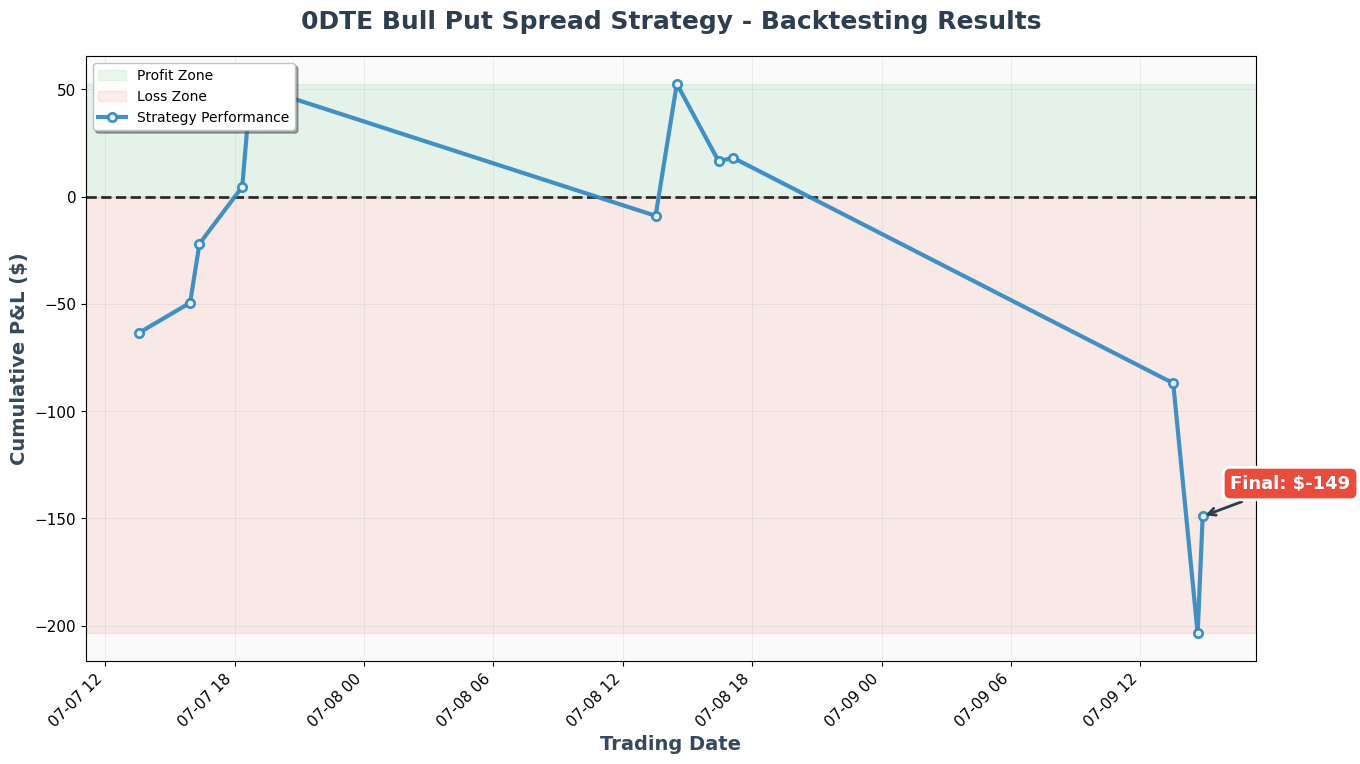

📊 BACKTESTING SUMMARY
Total Trades: 12
Total P&L: $-148.99
Win Rate: 58.3%
Average Trade: $-12.42
Best Trade: $61.50
Worst Trade: $-116.50


In [348]:
# Convert to DataFrame and calculate cumulative P&L
df = pd.DataFrame(all_results)
df['cumulative_pnl'] = df['theoretical_pnl'].cumsum()

# Convert entry_time to datetime and extract date
df['entry_time'] = pd.to_datetime(df['entry_time'])

# Enhanced plotting with professional styling
plt.style.use('default')  # Reset to clean style
plt.figure(figsize=(14, 8))

# Define professional color scheme
line_color = '#2E86C1'      # Professional blue
profit_color = '#28B463'    # Success green
loss_color = '#E74C3C'      # Alert red
grid_color = '#BDC3C7'      # Light gray

# Set background color
plt.gca().set_facecolor('#FAFAFA')

# Add profit/loss zones with background colors
max_pnl = df['cumulative_pnl'].max()
min_pnl = df['cumulative_pnl'].min()
if max_pnl > 0:
    plt.axhspan(0, max_pnl, alpha=0.1, color=profit_color, label='Profit Zone')
if min_pnl < 0:
    plt.axhspan(min_pnl, 0, alpha=0.1, color=loss_color, label='Loss Zone')

# Enhanced main line plot
plt.plot(df['entry_time'], df['cumulative_pnl'], 
         linewidth=3, color=line_color, marker='o', 
         markersize=6, markerfacecolor='white', 
         markeredgecolor=line_color, markeredgewidth=2,
         alpha=0.9, label='Strategy Performance', zorder=3)

# Enhanced zero line
plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.8, zorder=2)

# Professional title and labels
plt.title('0DTE Bull Put Spread Strategy - Backtesting Results', 
          fontsize=18, fontweight='bold', pad=20, color='#2C3E50')
plt.xlabel('Trading Date', fontsize=14, fontweight='600', color='#34495E')
plt.ylabel('Cumulative P&L ($)', fontsize=14, fontweight='600', color='#34495E')

# Enhanced grid
plt.grid(True, alpha=0.4, linestyle='-', linewidth=0.5, color=grid_color)

# Calculate performance statistics
final_pnl = df['cumulative_pnl'].iloc[-1]
max_profit = df['cumulative_pnl'].max()
max_drawdown = df['cumulative_pnl'].min()
win_rate = (df['theoretical_pnl'] > 0).mean() * 100
total_trades = len(df)

# Enhanced final P&L annotation
plt.annotate(f'Final: ${final_pnl:.0f}', 
             xy=(df['entry_time'].iloc[-1], final_pnl),
             xytext=(20, 20), textcoords='offset points',
             fontsize=13, fontweight='bold', color='white',
             bbox=dict(boxstyle="round,pad=0.4", 
                      facecolor=profit_color if final_pnl > 0 else loss_color,
                      edgecolor='white', linewidth=2),
             arrowprops=dict(arrowstyle='->', color='#2C3E50', lw=2))

# Improve date formatting and rotation
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

# Add legend
plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, 
          fontsize=10, edgecolor='#BDC3C7')

# Enhanced layout
plt.tight_layout(pad=2.0)
plt.show()

# Enhanced summary with better formatting
print("="*50)
print("📊 BACKTESTING SUMMARY")
print("="*50)
print(f"Total Trades: {len(df)}")
print(f"Total P&L: ${df['theoretical_pnl'].sum():.2f}")
print(f"Win Rate: {(df['theoretical_pnl'] > 0).mean()*100:.1f}%")
print(f"Average Trade: ${df['theoretical_pnl'].mean():.2f}")
print(f"Best Trade: ${df['theoretical_pnl'].max():.2f}")
print(f"Worst Trade: ${df['theoretical_pnl'].min():.2f}")
print("="*50)